# Denoising Diffusion Probabilistic Models with miniai

## Imports

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1' # only one gpu on device

In [2]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [5]:
from types import SimpleNamespace

In [6]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [7]:
def abar(t, T): return (t/T*math.pi/2).cos()**2

In [8]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts,n_steps)
    alp = ab/abar(ts-1,n_steps)
    return SimpleNamespace(a=alp, abar=ab, sig=(1-alp).sqrt())

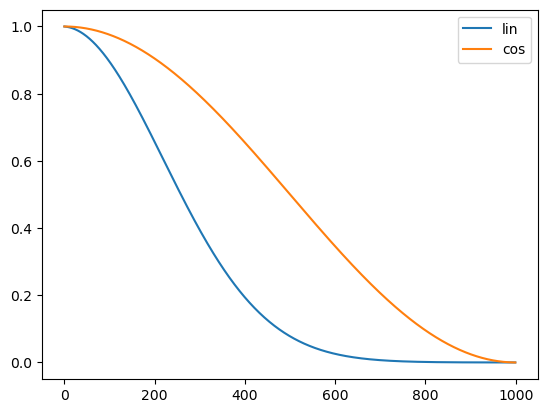

In [9]:
lin_abar = linear_sched().abar
cos_abar = cos_sched().abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

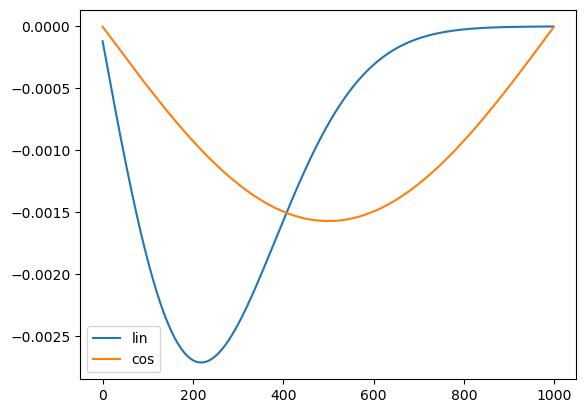

In [10]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

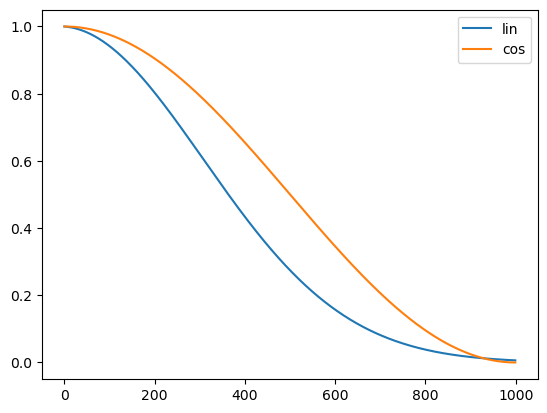

In [11]:
lin_abar = linear_sched(betamax=0.01).abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

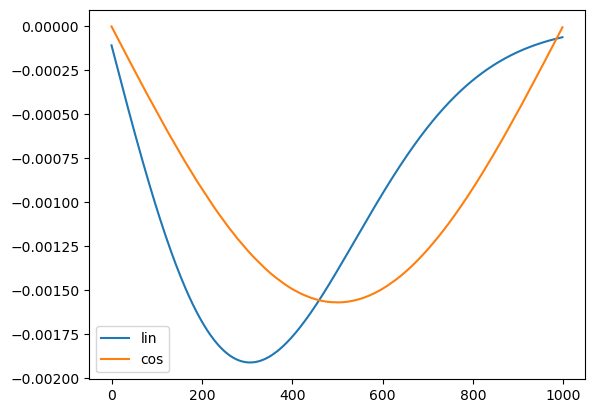

In [12]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

In [13]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [14]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [15]:
dt = dls.train
xb,yb = next(iter(dt))

In [16]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([ 26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572, 315, 295,
        567, 706, 749, 876,  73, 111, 899, 213, 541, 769, 287])

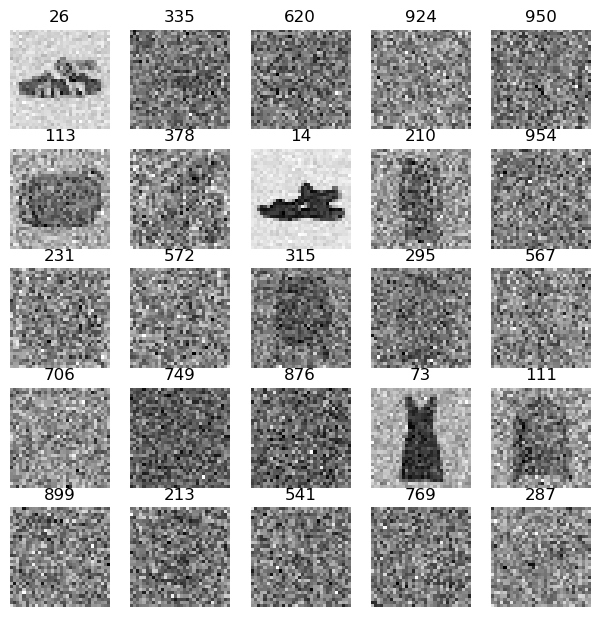

In [17]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25], imsize=1.5, titles=titles)

## Training

In [18]:
from diffusers import UNet2DModel

In [19]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [20]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [21]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [22]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [23]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.201,0,train
0.040,0,eval
0.035,1,train
0.033,1,eval
0.031,2,train
0.032,2,eval
0.030,3,train
0.031,3,eval
0.028,4,train
0.033,4,eval


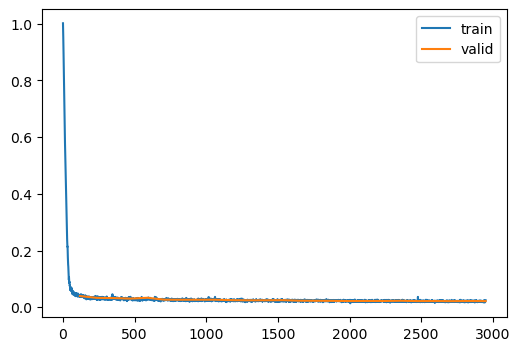

In [24]:
learn.fit(epochs)

In [25]:
mdl_path = Path('models')

In [26]:
torch.save(learn.model, mdl_path/'fashion_ddpm3_25.pkl')

In [27]:
model = torch.load(mdl_path/'fashion_ddpm3_25.pkl').cuda()

/tmp/ipykernel_4734/1107997880.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(mdl_path/'fashion_ddpm3_25.pkl').cuda()


In [28]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [29]:
n_samples = 512

In [30]:
%%time
samples = sample(model, (n_samples, 1, 32, 32))

CPU times: user 1min 7s, sys: 910 ms, total: 1min 8s
Wall time: 1min 8s


In [31]:
s = (samples[-1]*2)#.clamp(-1,1)
s.min(),s.max()

(tensor(-1.0702), tensor(1.3751))

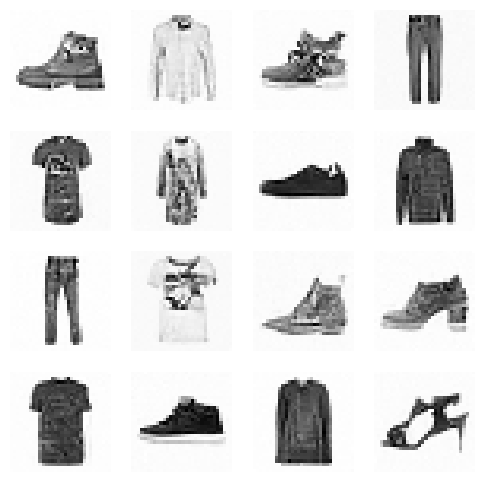

In [32]:
show_images(s[:16], imsize=1.5)

In [33]:
@inplace
def transformi2(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds2 = dsd.with_transform(transformi2)
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=fc.defaults.cpus)

cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

/tmp/ipykernel_4734/1956250179.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load('models/data_aug2.pkl')


In [34]:
from miniai.fid import ImageEval

In [35]:
ie = ImageEval(cmodel, dls2, cbs=[DeviceCB()])

In [36]:
ie.fid(s)

14.3533935546875

In [37]:
s.min(),s.max()

(tensor(-1.0702), tensor(1.3751))

In [38]:
ie.fid(xb*2)

6.220947265625

### Skip sampling

In [39]:
@torch.no_grad()
def sample_skip(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t%3==0 or t<50: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu().float())
    return preds

In [40]:
%%time
samples = sample_skip(model, (n_samples, 1, 32, 32))

CPU times: user 27.4 s, sys: 888 ms, total: 28.3 s
Wall time: 27.3 s


In [41]:
s = (samples[-1]*2)#.clamp(-1,1)

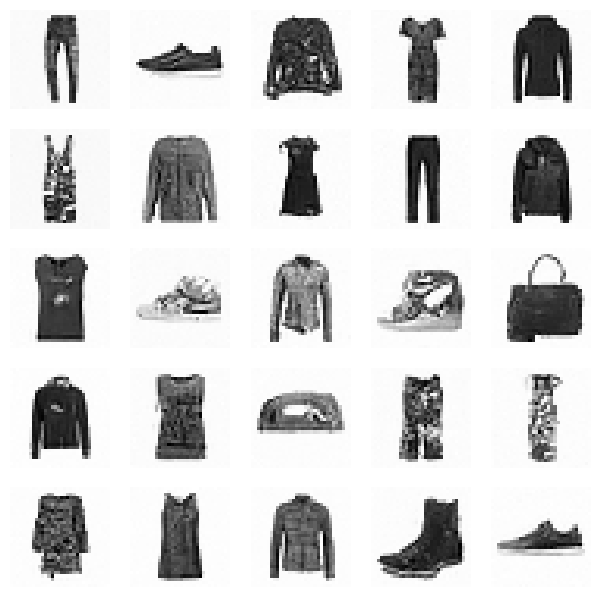

In [42]:
show_images(s[:25], imsize=1.5)

In [43]:
ie.fid(s)

15.8035888671875

In [44]:
@torch.no_grad()
def sample2(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t in sample_at: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        if t in sample_at: preds.append(x_t.float().cpu())
    return preds

In [45]:
%%time
samples = sample2(model, (n_samples, 1, 32, 32))

CPU times: user 23.3 s, sys: 413 ms, total: 23.7 s
Wall time: 21.9 s


In [46]:
s = (samples[-1]*2)#.clamp(-1,1)

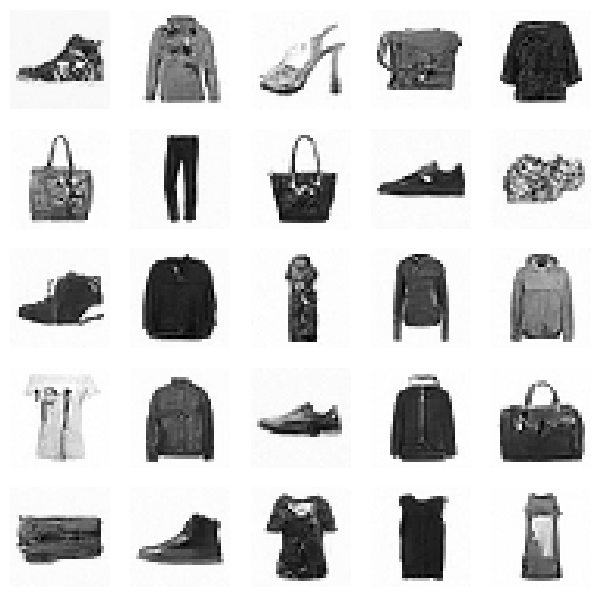

In [47]:
show_images(s[:25], imsize=1.5)

In [48]:
ie.fid(s)

12.04345703125